In [67]:
#SciKit DSC540 HW1
'''created by Casey Bennett 2018, www.CaseyBennett.com'''

import sys
import csv
import math
import pandas as pd
import numpy as np
from operator import itemgetter
import time
import joblib
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import scale
#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


#############################################################################
#
# Global parameters
#
#####################

target_idx=0                                        #Index of Target variable
cross_val=1                                         #Control Switch for CV                                                                                      
norm_target=0                                       #Normalize target switch
norm_features=0                                     #Normalize target switch
binning=0                                           #Control Switch for Bin Target
bin_cnt=2                                           #If bin target, this sets number of classes
feat_select=1                                       #Control Switch for Feature Selection
fs_type=4                                           #Feature Selection type (1=Stepwise Backwards Removal, 2=Wrapper Select, 3=Univariate Selection)
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features

#Set global model parameters
rand_st=1                                           #Set Random State variable for randomizing splits on runs


#############################################################################
#
# Load Data
#
#####################

file1= csv.reader(open('noindexweirdtest1.csv'), delimiter=',', quotechar='"')

#Read Header Line
header=next(file1)            

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            temp.append(float(row[j]))

    #Load temp into Data array
    data.append(temp)
  
#Test Print
print(header)
print(len(target),len(data))
print('\n')

data_np=np.asarray(data)
target_np=np.asarray(target)


#############################################################################
#
# Preprocess data
#
##########################################



if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)



#############################################################################
#
# Feature Selection
#
##########################################

#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                          #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected:', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    #Wrapper Select via model
    if fs_type==2:
        clf = RandomForestClassifier(n_estimators = 200, max_depth = None, min_samples_split = 3, criterion = 'entropy', random_state = rand_st)            
        sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                   
        print ('Wrapper Select: ')

        fit_mod=sel.fit(data_np, target_np)    
        sel_idx=fit_mod.get_support()

    if fs_type==4:
        clf=RandomForestClassifier(n_estimators = 200, max_depth = None, min_samples_split = 3, criterion = 'entropy', random_state = rand_st)
        clf.fit(data_np, target_np)
        sel_idx = []
        for x in clf.feature_importances_:
            if (x >= np.mean(clf.feature_importances_)):
                sel_idx.append(1)
            else:
                sel_idx.append(0)
        
        

    ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Selected:', temp)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
               
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index
    

#############################################################################
#
# Train SciKit Models
#
##########################################

print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

####Classifiers####
if cross_val==0:    
    #SciKit Random Forest
    clf = RandomForestClassifier(n_estimators = 100, max_depth = None, min_samples_split = 3, criterion = 'entropy', random_state = rand_st)   
    clf.fit(data_train, target_train)

    scores_ACC = clf.score(data_test, target_test)                                                                                                                          
    print('Random Forest Acc:', scores_ACC)
    scores_AUC = metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1])                                                                                      
    print('Random Forest AUC:', scores_AUC)                                                                     #AUC only works with binary classes, not multiclass            
 
####Cross-Val Classifiers####
if cross_val==1:
    #Setup Crossval classifier scorers
    scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}                                                                                                                
    
    #SciKit Random Forest - Cross Val
    start_ts=time.time()
    clf = RandomForestClassifier(n_estimators = 200, max_depth = None, min_samples_split = 3, criterion = 'entropy', random_state = rand_st)   
    kf = KFold(n_splits=5)
    scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=kf)                                                                                              

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
    scores_AUC= scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
    print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
    print("CV Runtime:", time.time()-start_ts)

['home_outcome', 'stage', 'B365H', 'B365D', 'B365A', 'year', 'on_target_shot_home_team', 'on_target_shot_away_team', 'off_target_shot_home_team', 'off_target_shot_away_team', 'foul_home_team', 'foul_away_team', 'yellow_card_home_team', 'yellow_card_away_team', 'red_card_home_team', 'red_card_away_team', 'crosses_home_team', 'crosses_away_team', 'corner_home_team', 'corner_away_team', 'possession_home_team', 'possession_away_team', 'starplayer_Away', 'starplayer_Home', 'starplayer_No']
3030 3030


--FEATURE SELECTION ON-- 

Selected: ['stage', 'B365H', 'B365D', 'B365A', 'on_target_shot_home_team', 'off_target_shot_home_team', 'off_target_shot_away_team', 'foul_home_team', 'foul_away_team', 'crosses_home_team', 'crosses_away_team', 'corner_home_team', 'possession_home_team', 'possession_away_team']
Features (total/selected): 24 14


--ML Model Output-- 

Random Forest Acc: 0.69 (+/- 0.04)
Random Forest AUC: 0.75 (+/- 0.04)
CV Runtime: 4.044245958328247


Text(0.5, 1.0, 'Convergence of Scores As # of Trees Increases')

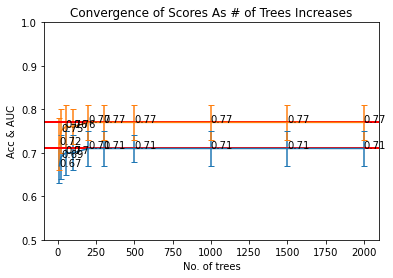

In [53]:
import matplotlib.pyplot as plt

plt.figure()
# function for a different figure
x = [10,20,50,100, 200, 300, 500,1000, 1500, 2000]
y = [0.67,0.69,0.70, 0.70,0.71,0.71, 0.71,0.71, 0.71, 0.71]
z = [0.72,0.75,0.76, 0.76,0.77,0.77, 0.77,0.77,0.77, 0.77]

yerr1 = [0.04, 0.05, 0.05, 0.04, 0.04, 0.04, 0.03, 0.04,0.04, 0.04]
yerr2 = [0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04,0.04, 0.04]
# plotting using plt.pyplot() Figure 2

plt.errorbar(x,y, yerr=yerr1, capsize=3)
plt.errorbar(x,z, yerr=yerr2, capsize=3)

for a,b in zip(x, y): 
    plt.text(a, b, str(b))
    
for c,d in zip(x, z): 
    plt.text(c, d, str(d))
    
plt.ylim([0.5,1])
# axis labeling
plt.xlabel('No. of trees')
plt.ylabel('Acc & AUC')
plt.axhline(y=0.71, color='r', linewidth=2)
plt.axhline(y=0.77, color='r', linewidth=2)
# figure name
plt.title('Convergence of Scores As # of Trees Increases')

In [80]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

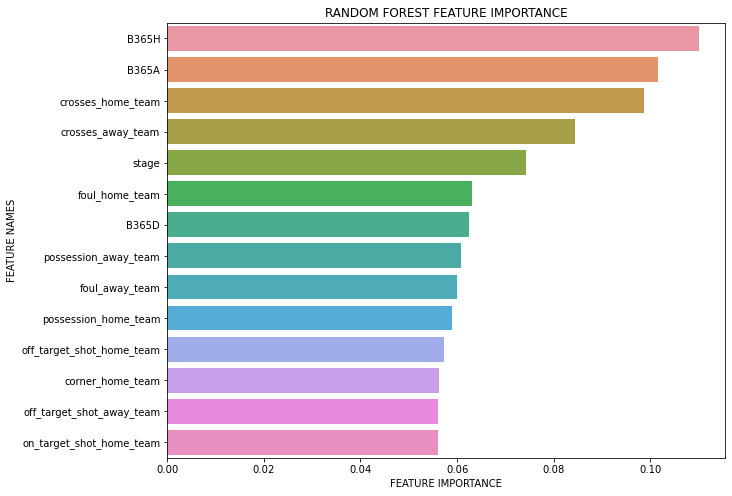

In [81]:
plot_feature_importance(clf.fit(data_np, target_np).feature_importances_,header[1:15],'RANDOM FOREST')

In [78]:
header[1:15]

['stage',
 'B365H',
 'B365D',
 'B365A',
 'on_target_shot_home_team',
 'off_target_shot_home_team',
 'off_target_shot_away_team',
 'foul_home_team',
 'foul_away_team',
 'crosses_home_team',
 'crosses_away_team',
 'corner_home_team',
 'possession_home_team',
 'possession_away_team']

In [72]:
len(temp)

14

In [ ]:
Wrapper Select: 
Selected: ['stage', 'B365H', 'B365D', 'B365A', 'on_target_shot_home_team', 'off_target_shot_home_team', 'off_target_shot_away_team', 'foul_home_team', 'foul_away_team', 'crosses_home_team', 'crosses_away_team', 'corner_home_team', 'possession_home_team', 'possession_away_team']
Features (total/selected): 24 14


--ML Model Output-- 

Random Forest Acc: 0.69 (+/- 0.04)
Random Forest AUC: 0.75 (+/- 0.04)
CV Runtime: 4.064138650894165